In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import csv
import glob
import librosa
import librosa.display
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import noisereduce as nr
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
from tqdm import tqdm
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

AUTOTUNE = tf.data.AUTOTUNE
AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
PREPROCESSED_EXTRACTED_FEATURES_FILE = 'preprocessed_extracted_features_iemocap.csv'
PREPROCESSED_ALL_EXTRACTED_FEATURES_FILE = 'all_preprocessed_extracted_features_iemocap.csv'
ALL_EXTRACTED_FEATURES_FILE = 'all_extracted_features_iemocap.csv'
RAW_AUDIO_FILES = 'raw_audio_files.csv'
AUDIO_SPECTROGRAMS_DIR = './../data/spectrograms/'
AUDIO_MFCCS_DIR = './../data/mfccs/'
AUDIO_MEL_SPECTROGRAMS_DIR = './../data/mel_spectrograms/'
AUDIO_SPECTROGRAM_IMAGES_DIR = './../data/spectrograms_images/'
AUDIO_MEL_SPECTROGRAM_IMAGES_DIR = './../data/mel_spectrograms_images/'
AUDIO_MFCCS_IMAGES_DIR = './../data/mfccs_images/'
AUDIO_ALL_DATA_DIR = './../data/all_data/'

CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)
plt.rcParams['figure.dpi'] = 300

## Extracting the 43 features selected from the eNTERFACE05 dataset study

In [2]:
all_headers = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance',
    'spikes_mel_spect', '25thpercentile_mel_spect', 'median_mel_spect', '75thpercentile_mel_spect', 'mean_mel_spect', 'min_mel_spect', 'max_mel_spect', 'var_mel_spect', 'std_mel_spect', 'sum_mel_spect',
    'spikes_chroma_stft', '25thpercentile_chroma_stft', 'median_chroma_stft', '75thpercentile_chroma_stft', 'mean_chroma_stft', 'var_chroma_stft', 'std_chroma_stft', 'sum_chroma_stft',
    'spikes_rms', '25thpercentile_rms', 'median_rms', '75thpercentile_rms', 'mean_rms', 'max_rms', 'var_rms', 'std_rms', 'sum_rms',
    'spikes_spec_cent', '25thpercentile_spec_cent', 'median_spec_cent', '75thpercentile_spec_cent', 'mean_spec_cent', 'min_spec_cent', 'max_spec_cent', 'var_spec_cent', 'std_spec_cent', 'sum_spec_cent',
    'spikes_spec_bw', '25thpercentile_spec_bw', 'median_spec_bw', '75thpercentile_spec_bw', 'mean_spec_bw', 'min_spec_bw', 'max_spec_bw', 'var_spec_bw', 'std_spec_bw', 'sum_spec_bw',
    'spikes_spec_rolloff', '25thpercentile_spec_rolloff', 'median_spec_rolloff', '75thpercentile_spec_rolloff', 'mean_spec_rolloff', 'min_spec_rolloff', 'max_spec_rolloff', 'var_spec_rolloff', 'std_spec_rolloff', 'sum_spec_rolloff',
    'spikes_spec_cont', '25thpercentile_spec_cont', 'median_spec_cont', '75thpercentile_spec_cont', 'mean_spec_cont', 'min_spec_cont', 'max_spec_cont', 'var_spec_cont', 'std_spec_cont', 'sum_spec_cont',
    'spikes_tonnetz', '25thpercentile_tonnetz', 'median_tonnetz', '75thpercentile_tonnetz', 'mean_tonnetz', 'min_tonnetz', 'max_tonnetz', 'var_tonnetz', 'std_tonnetz', 'sum_tonnetz',
    'spikes_zcr', '25thpercentile_zcr', 'median_zcr', '75thpercentile_zcr', 'mean_zcr', 'min_zcr', 'max_zcr', 'var_zcr', 'std_zcr', 'sum_zcr'
]

for i in range(1, 21):
    all_headers.extend([f'kurtosis_mfcc{i}', f'skew_mfcc{i}', f'spikes_mfcc{i}', f'25thpercentile_mfcc{i}', f'median_mfcc{i}',
                       f'75thpercentile_mfcc{i}', f'mean_mfcc{i}', f'min_mfcc{i}', f'max_mfcc{i}', f'var_mfcc{i}', f'std_mfcc{i}', f'sum_mfcc{i}'])

headers = [
    'File', 'Interaction', 'Gender', 'Original_Duration', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance',
    'min_zcr', 'spikes_zcr', 'var_mel_spect', 'spikes_mel_spect', 'thpercentile25_chroma_stft',
    'spikes_chroma_stft', 'mean_spec_bw', 'max_spec_bw', 'thpercentile25_rms', 'var_mfcc1', 'var_mfcc3', 'max_mfcc5',
    'var_mfcc5', 'median_mfcc5', 'spikes_mfcc6', 'thpercentile75_mfcc7', 'max_mfcc7', 'var_mfcc8',
    'sum_mfcc10', 'max_mfcc10', 'thpercentile75_mfcc11', 'max_mfcc11', 'sum_mfcc12', 'kurtosis_mfcc12',
    'mean_mfcc13', 'mean_mfcc15', 'spikes_mfcc16', 'kurtosis_mfcc17', 'mean_mfcc17', 'kurtosis_mfcc18',
    'spikes_mfcc19', 'mean_mfcc19', 'mean_mfcc20'
]

headers_raw = [
    'File', 'Interaction', 'Gender', 'Duration', 'Emotion', 'Emotion_Id',
    'Valence', 'Activation', 'Dominance'
]

emotion_label = {
    'ang': "angry", 'hap': "happy", 'sad': "sad", 'neu': "neutral",
    'fru': "frustrated", 'exc': "happy", 'fea': "fearful",
    'sur': "surprised", 'dis': "disgusted", 'xxx': "other", 'oth': "other"
}

emotion_number = {
    'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3, 'fru': 4,
    'exc': 1, 'fea': 6, 'sur': 7, 'dis': 8, 'oth': 9, 'xxx': 9
}


In [3]:
def spikes(data):
    if len(data.shape) != 1:
        data = np.concatenate(data)
    mean = np.mean(data)
    std = np.std(data)
    threshold = mean + np.abs(std) * 2 / 100
    num_spikes = 0
    for value in data:
        if value >= threshold:
            num_spikes += 1
    num_spikes = num_spikes / len(data)
    return num_spikes

In [4]:
def preprocess_audio(y, sr):
    y = nr.reduce_noise(y=y, sr=sr, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1)
    y, _ = librosa.effects.trim(y, top_db=30)
    return y

In [5]:
def extract_all_features(audio_file, emotion, valence, activation, dominance, writer, preprocess=False, analysis=False):
    file = audio_file.split(".")[-2].split("/")[-1]
    acting = "improvised" if file.split("_")[1][:5] == "impro" else "scripted"
    gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"

    y, sr = librosa.load(audio_file, sr=16000)
    duration = librosa.get_duration(y, sr)

    if preprocess:
        y = preprocess_audio(y, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.n_mels)
    rms = librosa.feature.rms(y=y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_cont = librosa.feature.spectral_contrast(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=y)

    if analysis:
        return [file, acting, gender, duration, emotion_label[emotion], emotion_number[emotion],\
            valence, activation, dominance, y, sr, mel_spect, mfcc, chroma_stft, rms, spec_cent,\
            spec_cont, spec_bw, spec_rolloff, zcr, tonnetz]    

    features_str = f'{file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
        {valence} {activation} {dominance}\
        {spikes(mel_spect)} {np.nanpercentile(mel_spect, 0.25)} {np.median(mel_spect)} {np.nanpercentile(mel_spect, 0.75)} {np.mean(mel_spect)} {np.min(mel_spect)} {np.max(mel_spect)} {np.var(mel_spect)} {np.std(mel_spect)} {np.sum(mel_spect)}\
        {spikes(chroma_stft)} {np.nanpercentile(chroma_stft, 0.25)} {np.median(chroma_stft)} {np.nanpercentile(chroma_stft, 0.75)} {np.mean(chroma_stft)} {np.var(chroma_stft)} {np.std(chroma_stft)} {np.sum(chroma_stft)}\
        {spikes(rms)} {np.nanpercentile(rms, 0.25)} {np.median(rms)} {np.nanpercentile(rms, 0.75)} {np.mean(rms)} {np.max(rms)} {np.var(rms)} {np.std(rms)} {np.sum(rms)}\
        {spikes(spec_cent)} {np.nanpercentile(spec_cent, 0.25)} {np.median(spec_cent)} {np.nanpercentile(spec_cent, 0.75)} {np.mean(spec_cent)} {np.min(spec_cent)} {np.max(spec_cent)} {np.var(spec_cent)} {np.std(spec_cent)} {np.sum(spec_cent)}\
        {spikes(spec_bw)} {np.nanpercentile(spec_bw, 0.25)} {np.median(spec_bw)} {np.nanpercentile(spec_bw, 0.75)} {np.mean(spec_bw)} {np.min(spec_bw)} {np.max(spec_bw)} {np.var(spec_bw)} {np.std(spec_bw)} {np.sum(spec_bw)}\
        {spikes(spec_rolloff)} {np.nanpercentile(spec_rolloff, 0.25)} {np.median(spec_rolloff)} {np.nanpercentile(spec_rolloff, 0.75)} {np.mean(spec_rolloff)} {np.min(spec_rolloff)} {np.max(spec_rolloff)} {np.var(spec_rolloff)} {np.std(spec_rolloff)} {np.sum(spec_rolloff)}\
        {spikes(spec_cont)} {np.nanpercentile(spec_cont, 0.25)} {np.median(spec_cont)} {np.nanpercentile(spec_cont, 0.75)} {np.mean(spec_cont)} {np.min(spec_cont)} {np.max(spec_cont)} {np.var(spec_cont)} {np.std(spec_cont)} {np.sum(spec_cont)}\
        {spikes(tonnetz)} {np.nanpercentile(tonnetz, 0.25)} {np.median(tonnetz)} {np.nanpercentile(tonnetz, 0.75)} {np.mean(tonnetz)} {np.min(tonnetz)} {np.max(tonnetz)} {np.var(tonnetz)} {np.std(tonnetz)} {np.sum(tonnetz)}\
        {spikes(zcr)} {np.nanpercentile(zcr, 0.25)} {np.median(zcr)} {np.nanpercentile(zcr, 0.75)} {np.mean(zcr)} {np.min(zcr)} {np.max(zcr)} {np.var(zcr)} {np.std(zcr)} {np.sum(zcr)}'

    for e in mfcc:
        features_str += f' {kurtosis(e)} {skew(e)} {spikes(e)} {np.nanpercentile(e, 0.25)} {np.median(e)} {np.nanpercentile(e, 0.75)} {np.mean(e)} {np.min(e)} {np.max(e)} {np.var(e)} {np.std(e)} {np.sum(e)}'

    writer.writerow(features_str.split())

In [6]:
def extract_features(audio_file, emotion, valence, activation, dominance, writer, preprocess=False): 
    file = audio_file.split(".")[-2].split("/")[-1]
    acting = "improvised" if file.split("_")[1][:5] == "impro" else "scripted"
    gender = "Male" if file.split("_")[-1][0] == 'M' else "Female"
    
    y, sr = librosa.load(audio_file, sr=16000)

    bef_prep_duration = librosa.get_duration(y, sr)
    aft_prep_duration = bef_prep_duration

    if preprocess:
        y = preprocess_audio(y, sr)
        aft_prep_duration = librosa.get_duration(y, sr)

    mfcc = librosa.feature.mfcc(y=y, sr=sr)

    zcr = librosa.feature.zero_crossing_rate(y=y)
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=config.n_mels)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    min_zcr = np.min(zcr)
    spikes_zcr = spikes(zcr)
    var_mel_spect = np.var(mel_spect)
    spikes_mel_spect = spikes(mel_spect)
    thpercentile25_chroma_stft = np.percentile(chroma_stft, 0.25)
    spikes_chroma_stft = spikes(chroma_stft)
    mean_spec_bw = np.mean(spec_bw)
    max_spec_bw = np.max(spec_bw)
    thpercentile25_rms = np.percentile(librosa.feature.rms(y=y), 0.25)

    var_mfcc1 = np.var(mfcc[0])
    var_mfcc3 = np.var(mfcc[2])
    max_mfcc5 = np.max(mfcc[4])
    var_mfcc5 = np.var(mfcc[4])
    median_mfcc5 = np.median(mfcc[4])
    spikes_mfcc6 = spikes(mfcc[5])
    thpercentile75_mfcc7 = np.percentile(mfcc[6], 0.75)
    max_mfcc7 = np.max(mfcc[6])
    var_mfcc8 = np.var(mfcc[7])
    sum_mfcc10 = np.sum(mfcc[9])
    max_mfcc10 = np.max(mfcc[9])
    thpercentile75_mfcc11 = np.percentile(mfcc[10], 0.75)
    max_mfcc11 = np.max(mfcc[10])
    sum_mfcc12 = np.sum(mfcc[11])
    kurtosis_mfcc12 = kurtosis(mfcc[11])
    mean_mfcc13 = np.mean(mfcc[12])
    mean_mfcc15 = np.mean(mfcc[14])
    spikes_mfcc16 = spikes(mfcc[15])
    kurtosis_mfcc17 = kurtosis(mfcc[16])
    mean_mfcc17 = np.mean(mfcc[16])
    kurtosis_mfcc18 = kurtosis(mfcc[17])
    spikes_mfcc19 = spikes(mfcc[18])
    mean_mfcc19 = np.mean(mfcc[18])
    mean_mfcc20 = np.mean(mfcc[19])

    features_str = f'{file} {acting} {gender} {bef_prep_duration} {aft_prep_duration} {emotion_label[emotion]} {emotion_number[emotion]}\
        {valence} {activation} {dominance}\
        {min_zcr} {spikes_zcr} {var_mel_spect} {spikes_mel_spect} {thpercentile25_chroma_stft}\
        {spikes_chroma_stft} {mean_spec_bw} {max_spec_bw} {thpercentile25_rms} {var_mfcc1} {var_mfcc3} {max_mfcc5}\
        {var_mfcc5} {median_mfcc5} {spikes_mfcc6} {thpercentile75_mfcc7} {max_mfcc7} {var_mfcc8}\
        {sum_mfcc10} {max_mfcc10} {thpercentile75_mfcc11} {max_mfcc11} {sum_mfcc12} {kurtosis_mfcc12}\
        {mean_mfcc13} {mean_mfcc15} {spikes_mfcc16} {kurtosis_mfcc17} {mean_mfcc17} {kurtosis_mfcc18}\
        {spikes_mfcc19} {mean_mfcc19} {mean_mfcc20}'

    writer.writerow(features_str.split())

In [7]:
def process_data(audio_dir, headers, proc_feat_dataset=EXTRACTED_FEATURES_FILE, all_features=False, preprocess=False):
    # Create a CSV for storing all processed features and write the header
    file = open(proc_feat_dataset, 'w', newline='')
    writer = csv.writer(file)
    writer.writerow(headers)

    print("Processing audio files from all dialogs:")
    for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
        emoEvalFile = open(file_path)

        for line in emoEvalFile:
            if line[0] == '[':
                args = line.split()
                if args[4] in {'ang', 'neu', 'exc', 'hap', 'sad'}:
                    # on windows
                    audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split(
                        "\\")[-1][:-4]+f'/{args[3]}.wav'
                    # on linux/macOS
                    # audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
                    if all_features:
                        extract_all_features(
                            audio_file, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], writer, preprocess)
                    else:
                        extract_features(
                            audio_file, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], writer, preprocess)


In [8]:
# process_data(AUDIO_DIR, headers)

In [9]:
process_data(AUDIO_DIR, headers, PREPROCESSED_EXTRACTED_FEATURES_FILE, preprocess=True)

Processing audio files from all dialogs:


100%|██████████| 151/151 [06:44<00:00,  2.68s/it]


In [12]:
process_data(AUDIO_DIR, all_headers, ALL_EXTRACTED_FEATURES_FILE, all_features=True)

Processing audio files from all dialogs:


100%|██████████| 151/151 [18:07<00:00,  7.20s/it]


In [152]:
process_data(AUDIO_DIR, all_headers, PREPROCESSED_ALL_EXTRACTED_FEATURES_FILE, all_features=True, preprocess=True)

Processing audio files from all dialogs:


100%|██████████| 151/151 [17:00<00:00,  6.76s/it]


In [55]:
emotion_number = {'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3, 'exc': 1}
emotion_label = {'ang': "angry", 'hap': "happy", 'sad': "sad", 'neu': "neutral", 'exc': "happy"}

def extract_raw_data(audio_dir, headers, raw_audio_dataset):
   file = open(raw_audio_dataset, 'w', newline='')
   writer = csv.writer(file)
   writer.writerow(headers)

   print("Processing audio files from all dialogs:")
   for file_path in tqdm(glob.glob(audio_dir+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
      emoEvalFile = open(file_path)

      for line in emoEvalFile:
         if line[0] == '[':
            args = line.split()
            duration = float(args[2][:-1]) - float(args[0][1:])
            # on windows
            emotion, valence, activation, dominance = args[4], args[5][1:-
                                                                       1], args[6][:-1], args[7][:-1]
            if emotion in emotion_label.keys():
                audio_file = f'{args[3]}-{emotion_number[emotion]}'
                acting = "improvised" if audio_file.split(
                    "_")[1][:5] == "impro" else "scripted"
                gender = "Male" if audio_file.split("_")[-1][0] == 'M' else "Female"

                features_str = f'{audio_file} {acting} {gender} {duration} {emotion_label[emotion]} {emotion_number[emotion]}\
                    {valence} {activation} {dominance}'

                writer.writerow(features_str.split())

In [56]:
extract_raw_data(AUDIO_DIR, headers_raw, RAW_AUDIO_FILES)

Processing audio files from all dialogs:


100%|██████████| 151/151 [00:00<00:00, 2251.87it/s]


In [21]:
emotion_number = {'ang': 0, 'hap': 1, 'sad': 2, 'neu': 3, 'exc': 1}

def extract_spectograms():
  for file_path in tqdm(glob.glob(AUDIO_DIR+'/Session[0-9]*/dialog/EmoEvaluation/*.txt')):
    for line in open(file_path):
      if line[0] == '[':
        args = line.split()
        emotion = args[4]
        if emotion not in emotion_number.keys():
          continue
        # on windows
        audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split(
            "\\")[-1][:-4]+f'/{args[3]}.wav'
        # on linux/macOS
        # audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/{file_path.split("/")[-1][:-4]}/{args[3]}.wav'
        filename = audio_file.split(".")[-2].split("/")[-1]

        y, sr = librosa.load(audio_file, sr=16000)
        y = preprocess_audio(y, sr)
        # Obtain 6 seconds of the audio waveform
        duration_seconds = 6
        y = librosa.util.fix_length(y, int(sr * duration_seconds))

        # ------------Spectrogram------------
        spec = np.abs(librosa.stft(y, n_fft=2048))
        # with open(f'{AUDIO_SPECTROGRAMS_DIR}{filename}-{emotion_number[emotion]}-spec.pickle', 'wb') as f:
        #   pickle.dump(spec, f, protocol=pickle.HIGHEST_PROTOCOL)


        # # ----------Mel-Spectrogram----------
        # mel_spec = librosa.feature.melspectrogram(S=spec, n_mels=256)
        # with open(f'{AUDIO_MEL_SPECTROGRAMS_DIR}{filename}-{emotion_number[emotion]}-mel.pickle', 'wb') as f:
        #   pickle.dump(mel_spec, f, protocol=pickle.HIGHEST_PROTOCOL)

        # # ---------------MFCCs---------------
        # mfcc = librosa.feature.mfcc(S=mel_spec, n_mfcc=40)
        # with open(f'{AUDIO_MFCCS_DIR}{filename}-{emotion_number[emotion]}-mfcc.pickle', 'wb') as f:
        #   pickle.dump(mfcc, f, protocol=pickle.HIGHEST_PROTOCOL)

        # ----------Spectrogram Image----------
        # fig = plt.figure(dpi=100)
        # ax = fig.add_subplot()
        # ax.axes.get_xaxis().set_visible(False)
        # ax.axes.get_yaxis().set_visible(False)
        # ax.set_frame_on(False)
        # spec = librosa.amplitude_to_db(np.abs(librosa.stft(y,  n_fft=2048, hop_length=512)), ref=np.max)
        # librosa.display.specshow(spec, sr=sr, hop_length=512, ax=ax, cmap="viridis_r")
        # fig.savefig(f'{AUDIO_SPECTROGRAM_IMAGES_DIR}{filename}-{emotion_number[emotion]}-spec_img.png',
        #             bbox_inches='tight', pad_inches=0, dpi=100)
        # fig.clf()
        # plt.close(fig)

        # -------Mel-Spectrogram Image-------
        # fig = plt.figure(dpi=100)
        # ax = fig.add_subplot()
        # ax.axes.get_xaxis().set_visible(False)
        # ax.axes.get_yaxis().set_visible(False)
        # ax.set_frame_on(False)
        # mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=2048, hop_length=512)
        # librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), cmap="viridis_r", ax=ax)
        # fig.savefig(f'{AUDIO_MEL_SPECTROGRAM_IMAGES_DIR}{filename}-{emotion_number[emotion]}-mel_img.png',
        #             bbox_inches='tight', pad_inches=0, dpi=100)
        # fig.clf()
        # plt.close(fig)

        # # ----------MFCCs Image----------
        # fig = plt.figure(dpi=100)
        # ax = fig.add_subplot()
        # ax.axes.get_xaxis().set_visible(False)
        # ax.axes.get_yaxis().set_visible(False)
        # ax.set_frame_on(False)
        # spec = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
        # mfcc = librosa.feature.mfcc(y=y, sr=sr, S=spec, n_mfcc=40)
        # librosa.display.specshow(mfcc, sr=sr, ax=ax, cmap="viridis_r")
        # fig.savefig(f'{AUDIO_MFCCS_IMAGES_DIR}{filename}-{emotion_number[emotion]}-mfcc_img.png',
        #             bbox_inches='tight', pad_inches=0, dpi=100)
        # fig.clf()
        # plt.close(fig)

        # --Spectrogram,MFCC,Mel-Spectrogram--
        # spec = np.abs(librosa.stft(y, n_fft=255, hop_length=755))
        # mfcc = librosa.feature.mfcc(y=y, sr=sr, S=spec, n_mfcc=128)
        # mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, S=spec, n_mels=128)
        # all = np.stack((spec, mfcc, mel_spec), axis=-1)
        # with open(f'{AUDIO_ALL_DATA_DIR}{filename}-{emotion_number[emotion]}-all.pickle', 'wb') as f:
        #   pickle.dump(all, f, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
extract_spectograms()

  0%|          | 0/151 [00:00<?, ?it/s]

(1025, 188)
(256, 188)
(40, 188)


In [160]:
def signal_analysis(axs, i, emotion, signal, sample_rate):
    # print(f'\tSample rate = {sample_rate}')
    # print(f'\tSignal mean = {np.mean(signal):.5f}')
    # print(f'\tSignal minimum = {np.std(signal):.5f}')
    # print(f'\tSignal maximum = {np.std(signal):.5f}')
    # print(f'\tSignal standard deviation = {np.std(signal):.5f}')
    # print(f'\tSignal variance = {np.std(signal):.5f}')
    # print(f'\tSignal sum = {np.sum(signal):.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    ax.set_title(emotion)
    librosa.display.waveshow(signal, sr=sample_rate, alpha=0.25, color='r', ax=ax)
    ax.plot()

In [161]:
def mel_spec_analysis(fig, axs, i, emotion, mel_spec):
    # print(f'\tMel-Spectogram mean = {np.mean(mel_spec):.5f}')
    # print(f'\tMel-Spectogram minimum = {np.std(mel_spec):.5f}')
    # print(f'\tMel-Spectogram maximum = {np.std(mel_spec):.5f}')
    # print(f'\tMel-Spectogram standard deviation = {np.std(mel_spec):.5f}')
    # print(f'\tMel-Spectogram variance = {np.std(mel_spec):.5f}')
    # print(f'\tMel-Spectogram sum = {np.sum(mel_spec):.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    im = ax.pcolormesh(mel_spec, cmap="magma")
    ax.set_title(emotion)
    fig.colorbar(im, ax=ax)

In [162]:
def mfcc_analysis(fig, axs, i, emotion, mfcc, sr):
    # print(f'\tMFCC shape = {mfcc.shape}')
    # print(f'\tMFCC mean = {np.mean(mfcc):.5f}')
    # print(f'\tMFCC minimum = {np.std(mfcc):.5f}')
    # print(f'\tMFCC maximum = {np.std(mfcc):.5f}')
    # print(f'\tMFCC standard deviation = {np.std(mfcc):.5f}')
    # print(f'\tMFCC variance = {np.std(mfcc):.5f}')
    # print(f'\tMFCC sum = {np.sum(mfcc):.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    im = librosa.display.specshow(mfcc, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [163]:
def chromogram_analysis(fig, axs, i, emotion, chromogram, sr):
    # print(f'\tChromogram mean = {np.mean(chromogram):.5f}')
    # print(f'\tChromogram minimum = {np.std(chromogram):.5f}')
    # print(f'\tChromogram maximum = {np.std(chromogram):.5f}')
    # print(f'\tChromogram standard deviation = {np.std(chromogram):.5f}')
    # print(f'\tChromogram variance = {np.std(chromogram):.5f}')
    # print(f'\tChromogram sum = {np.sum(chromogram):.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    im = librosa.display.specshow(chromogram, sr=sr, x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [164]:
def tonnetz_analysis(fig, axs, i, emotion, tonnetz, sr):
    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    im = librosa.display.specshow(tonnetz, sr=sr, y_axis='tonnetz', x_axis='time', ax=ax)
    ax.set_title(emotion)
    ax.plot()
    fig.colorbar(im, ax=ax)

In [165]:
def spec_analysis(axs, i, emotion, spec_cent, spec_bw, spec_rolloff, y, sr):
    spectral_centroids = np.concatenate(spec_cent)
    # print(f'\tSpectral Centroids mean = {np.mean(spectral_centroids):.5f}')
    spec_bw = np.concatenate(spec_bw)
    # print(f'\tSpectral Bandwidth mean = {np.mean(spec_bw):.5f}')
    spectral_rolloff = np.concatenate(spec_rolloff)
    # print(f'\tSpectral Rolloff mean = {np.mean(spectral_rolloff):.5f}')
    
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    
    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    ax.set_title(emotion)

    librosa.display.waveshow(y, sr=sr, alpha=0.25, ax=ax)
    ax.plot(t, spectral_centroids, color='b', label="Spectral Centroids")
    ax.plot(t, spec_bw, color='g', label="Spectral Bandwidth")
    ax.plot(t, spectral_rolloff, color='r', label="Spectral Rolloff")
    ax.legend()
    ax.plot()

In [166]:
def rmse_analysis(axs, i, emotion, rmse):
    rmse = np.concatenate(rmse)
    # print(f'\tRMSE mean = {np.mean(rmse):.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(rmse)

In [189]:
import matplotlib.patches as mpatches

def zcr_analysis(axs, i, emotion, zcrs, spikes=False):
    zcrs = np.concatenate(zcrs)
    mean = np.mean(zcrs)
    # print(f'\tZero Crossing Rate mean = {mean:.5f}')

    ax = axs[0 if i < 2 else 1, i if i < 2 else i - 2]
    ax.set_title(emotion)
    ax.grid()
    ax.plot(zcrs)

    if spikes:
        std = np.std(zcrs)
        threshold = mean + np.abs(std) * 2 / 100

        ax.axhline(y=threshold, color='r', linestyle='-')

        for i, value in enumerate(zcrs):
            if value >= threshold:
                ax.plot(i, value, marker="o", markersize=8, markeredgecolor="red", markerfacecolor="green")
        

In [167]:
def audio_analysis(df):
    sig_fig, sig_axs = plt.subplots(2, 2, figsize=(10, 6))
    mel_fig, mel_axs = plt.subplots(2, 2, figsize=(10, 6))
    mfcc_fig, mfcc_axs = plt.subplots(2, 2, figsize=(10, 6))
    chrom_fig, chrom_axs = plt.subplots(2, 2, figsize=(10, 6))
    ton_fig, ton_axs = plt.subplots(2, 2, figsize=(10, 6))
    spec_fig, spec_axs = plt.subplots(2, 2, figsize=(10, 6))
    rmse_fig, rmse_axs = plt.subplots(2, 2, figsize=(10, 6))
    zcr_fig, zcr_axs = plt.subplots(2, 2, figsize=(10, 6))
    zcr_spikes_fig, zcr_spikes_axs = plt.subplots(2, 2, figsize=(10, 6))

    # sig_fig.suptitle("Signal Waveplot")
    # mel_fig.suptitle("Log-Mel Magnitude Spectrogram")
    # mfcc_fig.suptitle("Mel-Frequency Cepstral Coefficients Spectrogram")
    # chrom_fig.suptitle("Chromogram Spectrogram")
    # spec_fig.suptitle("Spectral Wave Plots")
    # rmse_fig.suptitle("Root Mean Square Energy Wave Plot")
    # zcr_fig.suptitle("Zero Crossing Rate Wave Plot")
    # zcr_spikes_fig.suptitle("Zero Crossing Rate Wave Plot Annotated with Spikes")

    for ax in sig_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Amplitude")
    for ax in mel_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Hz")
    for ax in spec_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Amplitude")
    for ax in rmse_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Root Mean Square")
    for ax in zcr_axs.flat:
        ax.set(ylabel="Zero Crossing Rate")
    for ax in zcr_spikes_axs.flat:
        ax.set(xlabel="Time in Seconds", ylabel="Zero Crossing Rate")

    for i in range(len(mel_axs.flat)):
        sig_axs.flat[i].label_outer()
        mel_axs.flat[i].label_outer()
        mfcc_axs.flat[i].label_outer()
        chrom_axs.flat[i].label_outer()
        ton_axs.flat[i].label_outer()
        spec_axs.flat[i].label_outer()
        rmse_axs.flat[i].label_outer()
        zcr_axs.flat[i].label_outer()
        zcr_spikes_axs.flat[i].label_outer()

    for num_fig, data in enumerate(df.iterrows()):
        if num_fig > 4:
            break
            
        file, features = data
        acting, gender, duration, emotion_label, emotion_number,\
            valence, activation, dominance, signal, sample_rate, mel_spec, mfcc, chromogram, rmse, spec_cent,\
            spec_cont, spec_bw, spec_rolloff, zcrs, tonnetz = features

        print(f"Data analysis for {gender} Subject and the emotion {emotion_label} ({file}):")

        signal_analysis(sig_axs, num_fig, emotion_label, signal, sample_rate)
        mel_spec_analysis(mel_fig, mel_axs, num_fig, emotion_label, mel_spec)
        mfcc_analysis(mfcc_fig, mfcc_axs, num_fig, emotion_label, mfcc, sample_rate)
        chromogram_analysis(chrom_fig, chrom_axs, num_fig, emotion_label, chromogram, sample_rate)
        tonnetz_analysis(ton_fig, ton_axs, num_fig, emotion_label, tonnetz, sample_rate)
        spec_analysis(spec_axs, num_fig, emotion_label, spec_cent, spec_bw, spec_rolloff, signal, sample_rate)
        rmse_analysis(rmse_axs, num_fig, emotion_label, rmse)
        zcr_analysis(zcr_axs, num_fig, emotion_label, zcrs)
        zcr_analysis(zcr_spikes_axs, num_fig, emotion_label, zcrs, True)
        print("\n")
    plt.show()

In [168]:
columns = ['File', 'Acting', 'Gender', 'Duration', 'Emotion_Label', 'Emotion_Id',\
    'valence', 'activation', 'dominance', 'signal', 'sample_rate',\
    'mel_spec', 'mfcc', 'chroma_stft', 'rms', 'spec_cent',\
    'spec_cont', 'spec_bw', 'spec_rolloff', 'zcr', 'tonnetz']
df = pd.DataFrame(columns=columns)
emotions_in_df = set()
for file_path in tqdm(glob.glob(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/*.txt')):
    emoEvalFile = open(file_path)
    for line in emoEvalFile:
        if line[0] == '[':
            args = line.split()
            if args[4] == 'exc':
                args[4] = 'hap'
            if args[4] in {'ang', 'neu', 'hap', 'sad'}:
                # on windows
                audio_file = f'{AUDIO_DIR}/Session{args[3][4]}/sentences/wav/'+file_path.split(
                    "\\")[-1][:-4]+f'/{args[3]}.wav'

                if audio_file.split("_")[-1][0]=="M" and args[4] not in emotions_in_df:
                    features = extract_all_features(
                                audio_file, args[4], args[5][1:-1], args[6][:-1], args[7][:-1], None, preprocess=True, analysis=True)

                    df = df.append(pd.DataFrame(features, index=columns).transpose(), ignore_index=True)
    #                 emotions_in_df.add(args[4])
    #         if len(emotions_in_df) == 4:
    #             break
    # if len(emotions_in_df) == 4:
    #     break

df = df.sort_values(['Emotion_Id'], ascending = (True))
df = df.set_index('File')
df.head()

100%|██████████| 28/28 [03:53<00:00,  8.34s/it]


,Acting,Gender,Duration,Emotion_Label,Emotion_Id,valence,activation,dominance,signal,sample_rate,mel_spec,mfcc,chroma_stft,rms,spec_cent,spec_cont,spec_bw,spec_rolloff,zcr,tonnetz
File,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_M011,improvised,Male,7.239937,angry,0,2.0000,4.0000,4.0000,"[-0.0017875329, -0.0017485501, -0.0015916878, ...",16000,"[[0.03236638, 0.1829632, 0.19450153, 0.1137427...","[[-342.9918, -263.45203, -260.79498, -286.7476...","[[0.61516386, 1.0, 1.0, 0.6779992, 0.06712376,...","[[0.021422662, 0.029852094, 0.034369163, 0.036...","[[1476.2423797644608, 1173.122882524086, 1043....","[[24.356128682977584, 28.27782570587553, 30.84...","[[1282.4002679148573, 941.6289748820279, 750.6...","[[2914.0625, 2140.625, 1851.5625, 1835.9375, 1...","[[0.044921875, 0.06591796875, 0.07763671875, 0...","[[0.01583113041808823, 0.04736462835644161, 0...."
Ses01F_script03_2_M040,scripted,Male,16.0,angry,0,1.0000,4.5000,5.0000,"[4.5437817e-05, -0.00047056508, -0.00024881167...",16000,"[[0.00064758677, 0.0021500245, 0.0030783906, 0...","[[-345.88922, -178.30092, -118.96992, -112.509...","[[0.18884356, 0.032670885, 0.008462513, 0.0036...","[[0.04065541, 0.09587674, 0.12171153, 0.143581...","[[1594.1474509979923, 2026.5134019790685, 2056...","[[10.296027049253604, 12.044462088327887, 15.8...","[[1504.4828003237908, 1382.1995871343995, 1306...","[[3218.75, 3460.9375, 3406.25, 3343.75, 3304.6...","[[0.078125, 0.13232421875, 0.18603515625, 0.20...","[[0.05142140942716049, -0.03409429716728389, 0..."
Ses01M_impro01_M020,improvised,Male,3.62,angry,0,1.5000,4.5000,4.0000,"[-0.001393242, -0.0063635544, -0.008902308, -0...",16000,"[[0.0050073154, 0.0029750546, 0.0022867017, 0....","[[-313.10522, -270.89957, -266.72742, -279.801...","[[0.16465703, 0.3000319, 0.2677231, 0.0404676,...","[[0.016612764, 0.019633302, 0.023370735, 0.022...","[[1419.60625305295, 1369.64221159057, 1434.064...","[[5.600424526036899, 10.95488045428384, 19.529...","[[1394.9156146188964, 1237.847217592726, 1277....","[[2648.4375, 2093.75, 2562.5, 3000.0, 2671.875...","[[0.05078125, 0.080078125, 0.11083984375, 0.11...","[[0.018747108584253474, 0.07218577389318755, 0..."
Ses01M_impro01_M025,improvised,Male,3.344937,angry,0,1.5000,4.0000,4.5000,"[0.00012673269, 0.0001663435, 0.00010089192, 0...",16000,"[[0.0015400932, 0.002567803, 0.007510816, 0.03...","[[-432.18414, -254.49634, -118.266975, -54.301...","[[0.28797734, 0.23988451, 0.10334286, 0.021862...","[[0.020964867, 0.08976288, 0.1596913, 0.226470...","[[1099.8009325392718, 1237.0846628227414, 1554...","[[21.326469515029004, 8.770060958780977, 13.50...","[[1126.9023825294423, 865.1741536478248, 1154....","[[1554.6875, 1570.3125, 2585.9375, 2687.5, 289...","[[0.0478515625, 0.0849609375, 0.11474609375, 0...","[[-0.013819495749317979, -0.001476788616664145..."
Ses01M_impro01_M030,improvised,Male,1.119938,angry,0,1.5000,3.0000,4.0000,"[0.0009727482, 0.0008450946, 0.0005640979, 0.0...",16000,"[[0.10415588, 0.50539106, 0.89795655, 0.884903...","[[-482.51013, -407.624, -322.02567, -235.39017...","[[0.50839853, 0.33591482, 1.0, 0.79756594, 0.1...","[[0.014712292, 0.044343986, 0.07569368, 0.1430...","[[433.0733022481406, 474.87705906886583, 643.9...","[[19.48990785642423, 25.78803072135667, 33.169...","[[737.8031742505993, 573.1087165049262, 643.56...","[[523.4375, 640.625, 804.6875, 929.6875, 1117....","[[0.01904296875, 0.03466796875, 0.05517578125,...","[[0.033010374020058825, 0.020860361251142146, ..."


Data analysis for Male Subject and the emotion angry (Ses01F_impro01_M011):


Data analysis for Male Subject and the emotion happy (Ses01M_impro03_M022):


Data analysis for Male Subject and the emotion sad (Ses01M_impro06_M020):


Data analysis for Male Subject and the emotion neutral (Ses01F_script01_1_M023):




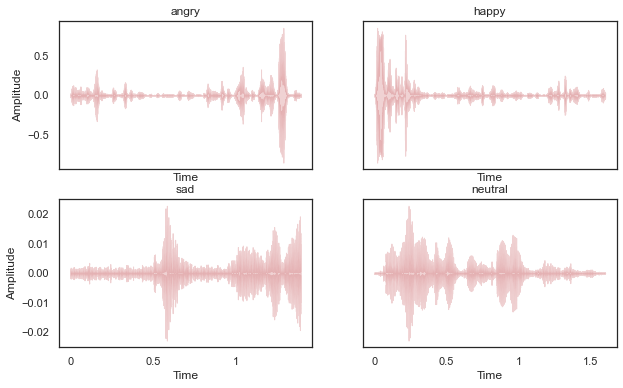

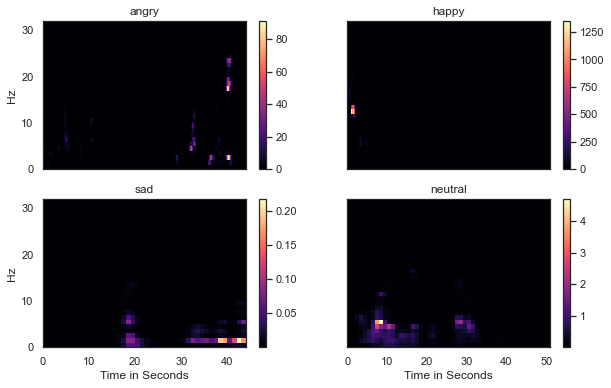

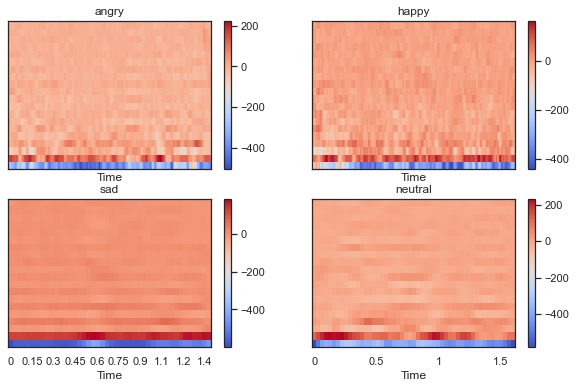

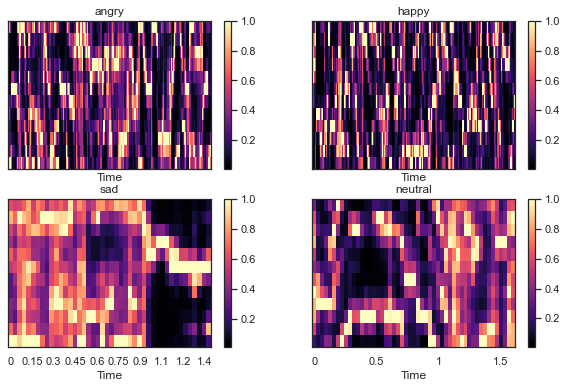

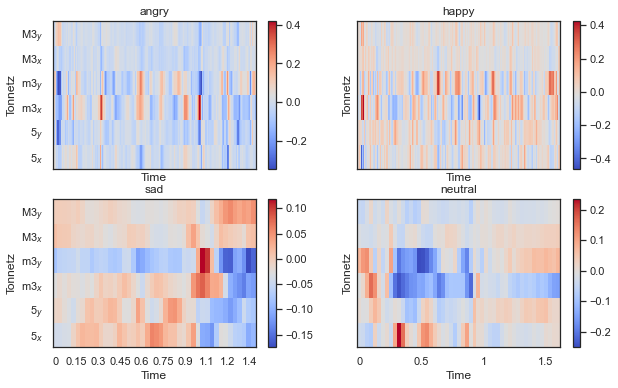

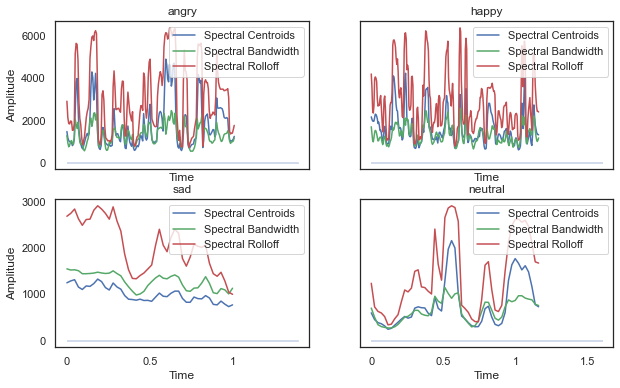

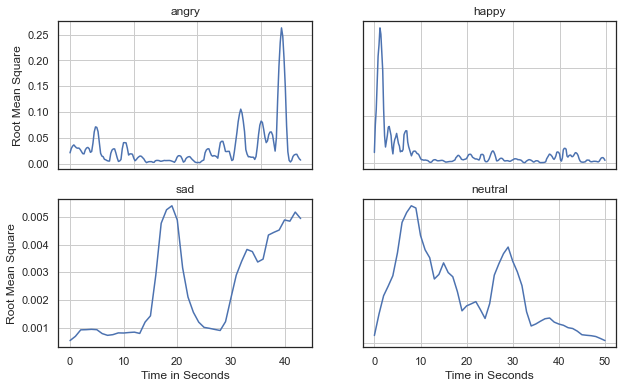

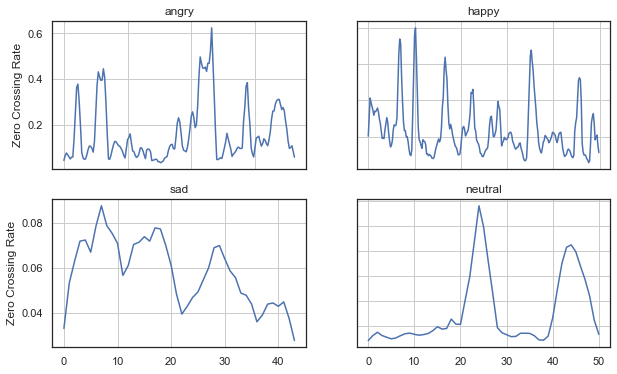

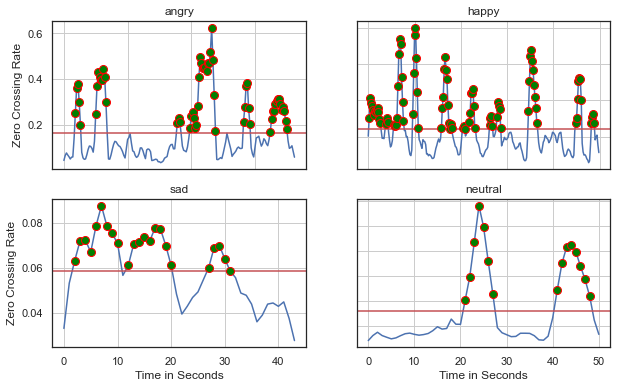

In [190]:
%matplotlib inline
audio_analysis(df.loc[df["Gender"].str.contains("M")].drop_duplicates("Emotion_Label"))

In [180]:
import seaborn as sns
sns.set_theme(style="white")
colors = ['b', 'g', 'r', 'y', 'k', 'm', 'c', 'w']

def analyse_feature(df, feature):
    grid = plt.GridSpec(6, 1, wspace=.1, hspace=.3)
    fig = plt.figure(figsize=(18, 28), tight_layout=True)
    # fig.suptitle(f"{feature} Analysis, 5 Subjects ({gender}), 1 Sentence", y=0.90, fontsize=18)
    emotions = {'angry': 'anger', 'happy': 'happiness', 'sad': 'sadness', 'neutral': 'neutral'}
    threshold = 0.04

    for i, emotion in enumerate(emotions):
        subj_df = df.loc[df["Emotion_Label"].str.contains(emotion) & df['Gender'].str.contains("M")]
        ax = plt.subplot(grid[i, :])
        ax.set_title(emotions[emotion])

        for i, data in enumerate(subj_df.iterrows()):
            _, data = data
            color = colors[i]
            zcr = np.array(data[feature])
            num_spikes = spikes(zcr)
            mean = np.mean(zcr)
            sum = np.sum(zcr)
            var = np.var(zcr)
            std = np.std(zcr)
            label = f"Mean: {mean:.03f}, Var: {var:.03f}, Std: {std:.03f}, Spikes: {num_spikes:.03f}, Sum: {sum:.03f}"
            zcr = np.concatenate(zcr)
            x = np.arange(len(zcr))
            ax.set(ylabel="Zero Crossing Rate")
            ax.plot(zcr, f'{color}-', label=label)
            ax.fill_between(x, zcr + threshold, zcr - threshold, color=color, alpha=0.2)
            ax.legend(loc="upper right")

    plt.show()

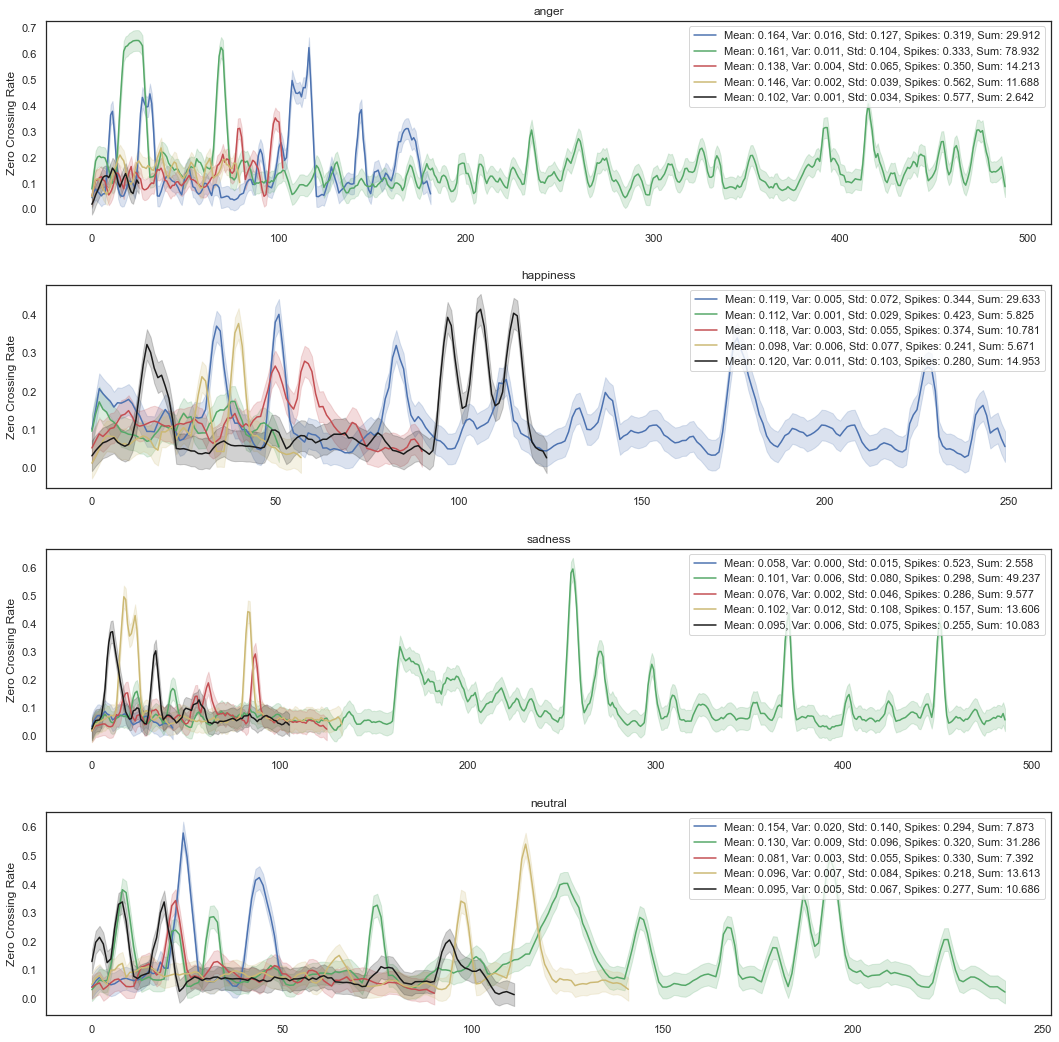

In [191]:
analyse_feature(df.groupby("Emotion_Label").head(5), 'zcr')

In [147]:
def analyse_feature_same_subject(df, feature):
    grid = plt.GridSpec(1, 1, wspace=.1, hspace=.4)
    fig = plt.figure(figsize=(16,5), tight_layout=True)
    threshold = 0.04

    ax = plt.subplot(grid[0, :])

    for i, data in enumerate(df.iterrows()):
        _, data = data
        color = colors[i]
        zcr = np.array(data[feature])
        num_spikes = spikes(zcr)
        mean = np.mean(zcr)
        sum = np.sum(zcr)
        var = np.var(zcr)
        std = np.std(zcr)
        label = f"Emotion: {data['Emotion_Label']}, Mean: {mean:.03f}, Var: {var:.03f}, Std: {std:.03f}, Spikes: {num_spikes:.03f}, Sum: {sum:.03f}"
        zcr = np.concatenate(zcr)
        x = np.arange(len(zcr))
        ax.plot(zcr, f'{color}-', label=label)
        ax.set(ylabel="Zero Crossing Rate")
        ax.fill_between(x, zcr + threshold, zcr - threshold, color=color, alpha=0.2)
    ax.legend()

    plt.show()

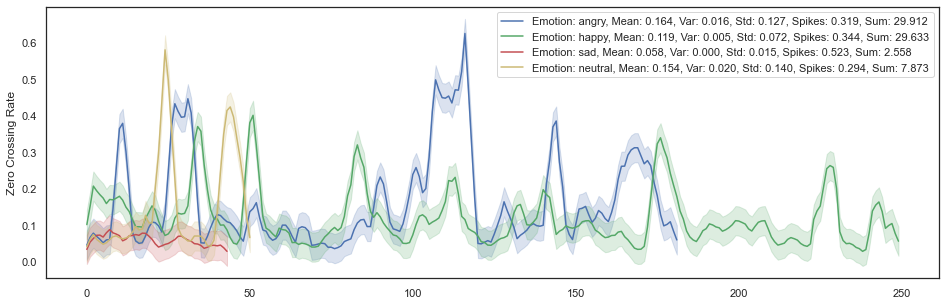

In [192]:
analyse_feature_same_subject(df.loc[df["Gender"].str.contains("M")].drop_duplicates("Emotion_Label"), 'zcr')